In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import hvplot.pandas
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Read In and Clean Data

In [2]:
# Read in data from csv file
wine_data = Path("Resources/winemag-data-130k-v2.csv")
# Convert to dataframe
wine_df = pd.read_csv(wine_data)
wine_df.head(5)

id   country                                        description  \
0   0     Italy  Aromas include tropical fruit, broom, brimston...   
1   1  Portugal  This is ripe and fruity, a wine that is smooth...   
2   2        US  Tart and snappy, the flavors of lime flesh and...   
3   3        US  Pineapple rind, lemon pith and orange blossom ...   
4   4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0                 Etna                NaN       Kerin O’Keefe   
1                  NaN                NaN          Roger Voss   
2    Willamette Valley  Willamette Valley        Paul Gregutt   
3  Lake Michigan Shore                NaN  Alexander Peartree   
4    Willamette Valley  Willamette Valley        Paul Gregutt   

  taster_twitter_handle                                              title  \
0          @kerinokeefe                  Nicosia 2013 Vulkà Bianco  (Etna)   
1            @vossroger      Quinta dos Avidagos 2011 Avidagos Red (Douro)   
2           @paulgwine       Rainstorm 2013 Pinot Gris (Willamette Valley)   
3                   NaN  St. Julian 2013 Reserve Late Harvest Riesling ...   
4           @paulgwine   Sweet Cheeks 2012 Vintner's Reserve Wild Child...   

          variety               winery  
0     White Blend              Nicosia  
1  Portuguese Red  Quinta dos Avidagos  
2      Pinot Gris            Rainstorm  
3        Riesling           St. Julian  
4      Pinot Noir         Sweet Cheeks

In [3]:
# Clean and transform data
# Drop unnecessary columns
df = wine_df.loc[:,["country", "description", "points",
                                    "province", "variety"]]
# Drop null values
df = df.dropna(how='any')
df.head(5)

country                                        description  points  \
0     Italy  Aromas include tropical fruit, broom, brimston...      87   
1  Portugal  This is ripe and fruity, a wine that is smooth...      87   
2        US  Tart and snappy, the flavors of lime flesh and...      87   
3        US  Pineapple rind, lemon pith and orange blossom ...      87   
4        US  Much like the regular bottling from 2012, this...      87   

            province         variety  
0  Sicily & Sardinia     White Blend  
1              Douro  Portuguese Red  
2             Oregon      Pinot Gris  
3           Michigan        Riesling  
4             Oregon      Pinot Noir

In [4]:
# List number of descriptions for each country
df["country"].value_counts()

country
US                        54504
France                    22093
Italy                     19540
Spain                      6645
Portugal                   5691
Chile                      4471
Argentina                  3800
Austria                    3345
Australia                  2329
Germany                    2165
New Zealand                1419
South Africa               1401
Israel                      505
Greece                      466
Canada                      257
Hungary                     146
Bulgaria                    141
Romania                     120
Uruguay                     109
Turkey                       90
Slovenia                     87
Georgia                      86
England                      74
Croatia                      73
Mexico                       70
Moldova                      59
Brazil                       52
Lebanon                      35
Morocco                      28
Peru                         16
Ukraine                      14


In [5]:
# Store the value counts as a variable
values = df["country"].value_counts() 

In [6]:
# Create list of country names to keep
countries_to_keep = ["US", "France", "Italy", "Spain", "Portugal", "Chile", "Argentina", "Austria",
                  "Australia", "Germany", "New Zealand", "South Africa"]

In [7]:
# Drop countries with less than 1000 descriptions
# Choose cutoff value to create list of countries
countries_to_replace = values.index[values<1000]

# Replace in dataframe
for ctry in countries_to_replace:
    df["country"] = df["country"].replace(ctry, "Other")

# Check to make sure binning was successful
df["country"].value_counts()

reduced_df=df.loc[df["country"].isin(countries_to_keep), :]
reduced_df.head()


country                                        description  points  \
0     Italy  Aromas include tropical fruit, broom, brimston...      87   
1  Portugal  This is ripe and fruity, a wine that is smooth...      87   
2        US  Tart and snappy, the flavors of lime flesh and...      87   
3        US  Pineapple rind, lemon pith and orange blossom ...      87   
4        US  Much like the regular bottling from 2012, this...      87   

            province         variety  
0  Sicily & Sardinia     White Blend  
1              Douro  Portuguese Red  
2             Oregon      Pinot Gris  
3           Michigan        Riesling  
4             Oregon      Pinot Noir

# Preprocess Data to Build Word2Vec Model

In [8]:
# Transform words into vectors using NLP
# Drop stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
reduced_df['description'] = reduced_df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
reduced_df.head()

[nltk_data] Downloading package stopwords to /Users/dzz_/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/_t/scbbyxlx46g2wd63k7994ztm0000gn/T/ipykernel_4154/608277938.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['description'] = reduced_df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


country                                        description  points  \
0     Italy  Aromas include tropical fruit, broom, brimston...      87   
1  Portugal  This ripe fruity, wine smooth still structured...      87   
2        US  Tart snappy, flavors lime flesh rind dominate....      87   
3        US  Pineapple rind, lemon pith orange blossom star...      87   
4        US  Much like regular bottling 2012, comes across ...      87   

            province         variety  
0  Sicily & Sardinia     White Blend  
1              Douro  Portuguese Red  
2             Oregon      Pinot Gris  
3           Michigan        Riesling  
4             Oregon      Pinot Noir

In [9]:
# Lemmatization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)
reduced_df['description'] = reduced_df['description'].apply(lemmatize_words)
reduced_df.head()

[nltk_data] Downloading package wordnet to /Users/dzz_/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/var/folders/_t/scbbyxlx46g2wd63k7994ztm0000gn/T/ipykernel_4154/2083711034.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['description'] = reduced_df['description'].apply(lemmatize_words)


country                                        description  points  \
0     Italy  Aromas include tropical fruit, broom, brimston...      87   
1  Portugal  This ripe fruity, wine smooth still structured...      87   
2        US  Tart snappy, flavor lime flesh rind dominate. ...      87   
3        US  Pineapple rind, lemon pith orange blossom star...      87   
4        US  Much like regular bottle 2012, come across rat...      87   

            province         variety  
0  Sicily & Sardinia     White Blend  
1              Douro  Portuguese Red  
2             Oregon      Pinot Gris  
3           Michigan        Riesling  
4             Oregon      Pinot Noir

In [10]:
# Tokenize descriptions to split sentences into word components
descriptions = reduced_df.description.apply(gensim.utils.simple_preprocess)
descriptions

0         [aromas, include, tropical, fruit, broom, brim...
1         [this, ripe, fruity, wine, smooth, still, stru...
2         [tart, snappy, flavor, lime, flesh, rind, domi...
3         [pineapple, rind, lemon, pith, orange, blossom...
4         [much, like, regular, bottle, come, across, ra...
                                ...                        
129966    [notes, honeysuckle, cantaloupe, sweeten, deli...
129967    [citation, give, much, decade, bottle, age, pr...
129968    [well, drained, gravel, soil, give, wine, cris...
129969    [dry, style, pinot, gris, crisp, acidity, it, ...
129970    [big, rich, off, dry, power, intense, spicines...
Name: description, Length: 127403, dtype: object

In [11]:
# Word2Vec model
# Create the model
model = gensim.models.Word2Vec(window=1, min_count=1, workers=8)
# Build its vocabulary
model.build_vocab(descriptions, progress_per=100)
# Train the model
model.train(descriptions, total_examples=model.corpus_count, epochs= model.epochs)
# Save the model to use later
model.save("Resources/descriptions.model")

In [12]:
# Test the model looking for similar words
model.wv.most_similar("bright")

[('vibrant', 0.8278583288192749),
 ('lively', 0.7354991436004639),
 ('fragrant', 0.7254149913787842),
 ('buoyant', 0.7126797437667847),
 ('fresh', 0.6952482461929321),
 ('zippy', 0.6939994692802429),
 ('vivid', 0.6917411684989929),
 ('vivacious', 0.689844012260437),
 ('pristine', 0.6750615835189819),
 ('zesty', 0.6705996990203857)]

In [13]:
# Test the model with similarity of different words
model.wv.similarity(w1="sweet",w2="fruity")

0.40554547

# Calculate Vector Representations of Descriptions

In [14]:
# Get vector representations of descriptions
# Define our function that creates description vectors:
def get_desc_vec(document):
    return np.array(sum(model.wv[word] for word in document)/len(document))

desc_vecs = descriptions.apply(get_desc_vec).tolist()


In [15]:
# Create a dataframe for the description vectors
desc_vec_df = pd.DataFrame(desc_vecs)

In [16]:
# Display dataframe
desc_vec_df.head()

0         1         2         3         4         5         6   \
0 -0.373594  0.155375 -0.270065  0.279137  0.132517 -0.543179  0.633235   
1 -0.357650  0.068855  0.136512  0.173074 -0.074080 -0.796957  0.483766   
2 -0.037364 -0.052054 -0.107438  0.198766  0.075321 -0.727884  0.454954   
3  0.028214  0.252700 -0.182691  0.126968  0.141081 -0.597060  0.452555   
4 -0.223669  0.405870 -0.026913  0.072149  0.087187 -0.348756  0.306454   

         7         8         9   ...        90        91        92        93  \
0  0.706796 -0.147186 -0.342999  ...  0.658817  0.365943  0.445079 -0.231406   
1  1.419661 -0.002219 -0.556103  ...  0.896666  0.082557  0.217462 -0.259445   
2  0.874601 -0.101778 -0.380910  ...  0.512896  0.351445  0.565866 -0.202878   
3  0.636611 -0.297842 -0.288713  ...  0.523433  0.235186  0.568739 -0.085875   
4  0.637713 -0.236679 -0.138142  ...  0.405503  0.132223  0.063702  0.133155   

         94        95        96        97        98        99  
0  0.398324  0.368437  0.252044 -0.038258 -0.217762  0.619223  
1  0.825786  0.146652  0.261485 -0.050383  0.249613  0.082372  
2  0.457840  0.272150  0.032805 -0.144718 -0.108565  0.529694  
3  0.445095  0.337412  0.180340 -0.282372 -0.329675  0.609689  
4  0.432090  0.089764  0.140266 -0.168807  0.315055 -0.063313  

[5 rows x 100 columns]

In [17]:
desc_vec_df.values

array([[-0.3735944 ,  0.1553748 , -0.27006465, ..., -0.03825838,
        -0.21776165,  0.61922294],
       [-0.35765046,  0.06885468,  0.13651198, ..., -0.05038268,
         0.24961276,  0.0823717 ],
       [-0.0373638 , -0.05205391, -0.10743751, ..., -0.14471777,
        -0.1085652 ,  0.52969444],
       ...,
       [-0.28846136,  0.06177187, -0.13371263, ...,  0.06503268,
         0.17415802,  0.04576671],
       [-0.3349243 ,  0.19516999, -0.12375798, ...,  0.08822563,
        -0.00278356,  0.1632924 ],
       [-0.2767505 ,  0.13680778, -0.00581524, ...,  0.04164891,
         0.23279813,  0.1961977 ]], dtype=float32)

# Build TSNE Model

In [18]:
# Save the labels into a variable l.
l = reduced_df['country']
 
# Drop the label feature and 
# Store the pixel data in d.
d = reduced_df.drop("description", axis=1)

In [19]:
# Data-preprocessing: Standardizing the data
standardized_data = StandardScaler().fit_transform(desc_vecs)
print(standardized_data.shape)

(127403, 100)


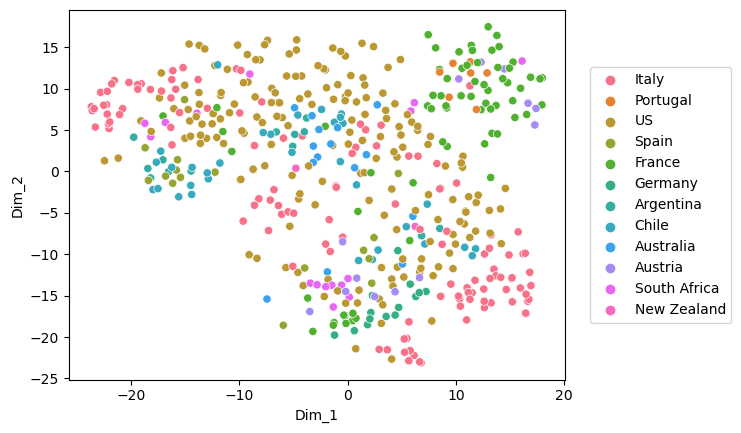

In [20]:
# Picking the top 1000 points as TSNE
# takes a lot of time for 15K points
data_500 = standardized_data[0:500, :]
labels_500 = l[0:500]
 
model = TSNE(n_components = 2, random_state = 0)
# configuring the parameters
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations
# for the optimization = 1000
 
tsne_data = model.fit_transform(data_500)
 
# creating a new data frame which
# help us in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels_500)).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))
 
# Plotting the result of tsne
g = sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
               hue='label')
custom_palette = sns.color_palette("dark")
g.legend(loc='right', bbox_to_anchor=(1.35, 0.5), ncol=1)
plt.show()

# Build KMeans Clusters

In [21]:
# Elbow Method to find the optimal number of clusters
num_clusters_range = range(1, 11)

wcss = []
for k in num_clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init = "auto")
    kmeans.fit(desc_vec_df)
    wcss.append(kmeans.inertia_)

# Create a DataFrame for the elbow curve
df_elbow = pd.DataFrame({"k_value": num_clusters_range, "inertia_value": wcss})

# Plot the elbow curve using hvplot
elbow_curve = df_elbow.hvplot.line(x="k_value", y="inertia_value", title="Elbow Curve")
elbow_curve

:Curve   [k_value]   (inertia_value)

In [22]:
# Apply k-means clustering with the optimal number of clusters
optimal_k = 4 # Add the optimal k value based on the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init = "auto")
cluster_assignments_kmeans = kmeans.fit_predict(desc_vec_df)

# Add the cluster assignments to new dataframe
desc_vec_kmeans_predictions_df = desc_vec_df.copy()
desc_vec_kmeans_predictions_df['kmeans_cluster'] = cluster_assignments_kmeans

# Plot the clusters
desc_vec_kmeans_predictions_df.hvplot.scatter(
    x="27",
    y="83",
    by="kmeans_cluster"
)

:NdOverlay   [kmeans_cluster]
   :Scatter   [27]   (83)

In [23]:
# Add KMeans cluster values to reduced dataframe
cluster_wine_df=reduced_df.copy()
cluster_wine_df["kmeans_cluster"]=cluster_assignments_kmeans

# Display the clusters
for cluster_id in range(optimal_k):
    print(f"Cluster {cluster_id}:")
    print(cluster_wine_df[cluster_wine_df['kmeans_cluster'] == cluster_id]['variety'].value_counts().head())
    print("\n")

Cluster 0:
variety
Pinot Noir                  6290
Cabernet Sauvignon          4155
Chardonnay                  3026
Red Blend                   2511
Bordeaux-style Red Blend    1923
Name: count, dtype: int64


Cluster 1:
variety
Red Blend             5659
Cabernet Sauvignon    4547
Pinot Noir            4226
Nebbiolo              2246
Syrah                 2157
Name: count, dtype: int64


Cluster 2:
variety
Chardonnay         6100
Riesling           4051
Sauvignon Blanc    3023
White Blend        1433
Sparkling Blend    1392
Name: count, dtype: int64


Cluster 3:
variety
Bordeaux-style Red Blend    3772
Chardonnay                  2322
Pinot Noir                  2191
Portuguese Red              1986
Rosé                        1376
Name: count, dtype: int64




# Utilize PCA Followed by KMeans Clustering

In [24]:
# Instantiate the PCA instance and declare the number of PCA variables
pca = PCA(n_components=2)

In [25]:
# Fit the PCA model on the vectors DataFrame
desc_vec_pca = pca.fit_transform(desc_vec_df)

# Review the first 5 rows of list data
desc_vec_pca[:5]

array([[-0.8137981 ,  0.5003986 ],
       [ 0.4503077 , -0.1253741 ],
       [-0.25648633,  1.0903249 ],
       [-0.72401273,  1.0323159 ],
       [ 0.8896401 , -0.33157232]], dtype=float32)

In [26]:
# Calculate the PCA explained variance ratio
pca.explained_variance_ratio_
print(pca.explained_variance_ratio_)
print("Total explained variance = .29")

[0.16075678 0.12869309]
Total explained variance = .29


In [27]:
# Create the PCA DataFrame
desc_vec_pca_df = pd.DataFrame(
    desc_vec_pca,
    columns=["PCA1", "PCA2"]
)

# Review the PCA DataFrame
desc_vec_pca_df.head()

PCA1      PCA2
0 -0.813798  0.500399
1  0.450308 -0.125374
2 -0.256486  1.090325
3 -0.724013  1.032316
4  0.889640 -0.331572

In [28]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=0, n_init = "auto")
    k_model.fit(desc_vec_pca_df)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

k       inertia
0  1  74284.625000
1  2  46972.421875
2  3  26601.439453
3  4  20878.906250
4  5  16017.289062

In [29]:
# Plot the Elbow Curve
df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)


:Curve   [k]   (inertia)

In [30]:
# Determine optimal number of clusters based on elbow frame above
print("Optimal number of clusters = 5")

Optimal number of clusters = 5


In [31]:
# Define the model with 5 clusters
cluster_number = 5
model = KMeans(n_clusters=cluster_number, random_state=0, n_init = "auto")

# Fit the model
model.fit(desc_vec_pca_df)

# Make predictions
k_5 = model.predict(desc_vec_pca_df)

# Create a copy of the PCA DataFrame
pca_to_cluster_df=desc_vec_pca_df.copy()

# Add a class column with the labels
pca_to_cluster_df["pca_clusters"] = k_5
pca_to_cluster_df.head()

PCA1      PCA2  pca_clusters
0 -0.813798  0.500399             4
1  0.450308 -0.125374             0
2 -0.256486  1.090325             4
3 -0.724013  1.032316             4
4  0.889640 -0.331572             0

In [32]:
# Plot the clusters
pca_to_cluster_df.hvplot.scatter(
    x="PCA1",
    y="PCA2",
    by="pca_clusters"
)

:NdOverlay   [pca_clusters]
   :Scatter   [PCA1]   (PCA2)

/Users/dzz_/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


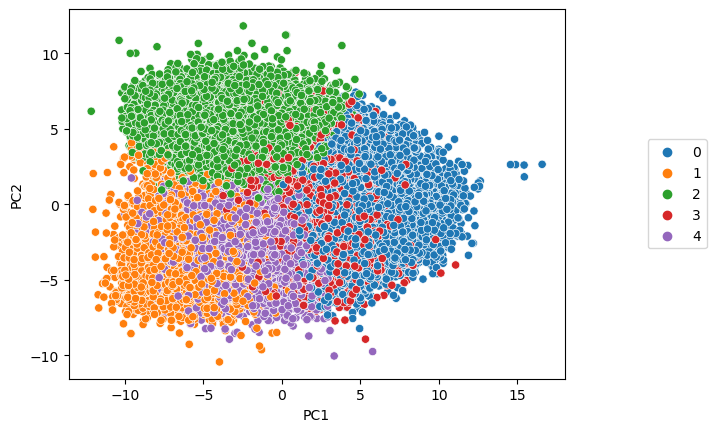

In [33]:
# Display PCA clusters with seaborn
Sc = StandardScaler()
X = Sc.fit_transform(desc_vec_df)
pca = PCA(2)
pca_data = pd.DataFrame(pca.fit_transform(X),columns=["PC1","PC2"])
kmeans =KMeans(n_clusters=5).fit(X)
pca_data["cluster"] = pd.Categorical(kmeans.labels_)
g = sns.scatterplot(data=pca_data, x="PC1", y="PC2",
               hue="cluster")
g.legend(loc="right", bbox_to_anchor=(1.3, 0.5), ncol=1)

In [34]:
# Add a class column with the labels for PCA clusters
cluster_wine_df["pca_clusters"] = k_5

for cluster_id in range(cluster_number):
    print(f"Cluster {cluster_id}:")
    print(cluster_wine_df[cluster_wine_df['pca_clusters'] == cluster_id]['variety'].value_counts().head())
    print("\n")

Cluster 0:
variety
Pinot Noir                  4094
Bordeaux-style Red Blend    2735
Cabernet Sauvignon          2451
Chardonnay                  1666
Red Blend                   1298
Name: count, dtype: int64


Cluster 1:
variety
Pinot Noir                  5722
Cabernet Sauvignon          4262
Bordeaux-style Red Blend    3367
Red Blend                   3354
Syrah                       2050
Name: count, dtype: int64


Cluster 2:
variety
Chardonnay         5766
Sauvignon Blanc    2529
Riesling           2151
Rosé               1654
White Blend        1097
Name: count, dtype: int64


Cluster 3:
variety
Red Blend             3791
Cabernet Sauvignon    2472
Pinot Noir            1995
Nebbiolo              1933
Sangiovese            1688
Name: count, dtype: int64


Cluster 4:
variety
Chardonnay         3691
Riesling           2683
Sauvignon Blanc    1770
Sparkling Blend     899
White Blend         822
Name: count, dtype: int64




# Use KNearestNeighbors to Predict Clusters

In [35]:
# Use K Nearest Neighbors to assign user input to a cluster

# Create dataframe with pca cluster column added to description vectors
desc_vec_with_pca_df = desc_vec_df.copy()
desc_vec_with_pca_df["pca_clusters"] = k_5

# Separate the target variable from the features
y = desc_vec_with_pca_df["pca_clusters"]
X = desc_vec_with_pca_df.drop(columns = "pca_clusters")

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=0, 
                                                    stratify=y)

#Instantiate the KNN model
neigh = KNeighborsClassifier(n_neighbors=3)

# Fit the model
neigh.fit(X_train, y_train)

# Save the model
# Possible code for the save:
#model = knn() # put yours model
#model.fit(X_train, Y_train)

# save the model to disk
#filename = 'finalized_model.sav'
#pickle.dump(model, open(filename, 'wb'))


# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)

KNeighborsClassifier(n_neighbors=3)

In [36]:
# Score the model using test data
print(f"Training Data Score: {neigh.score(X_train, y_train)}")
print(f"Testing Data Score: {neigh.score(X_test, y_test)}")

Training Data Score: 0.9389756363027462
Testing Data Score: 0.869768610090735


In [37]:
# Make predictions using the test data
predictions = neigh.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(10)

Prediction  Actual
0           4       4
1           3       3
2           0       0
3           1       3
4           1       1
5           0       0
6           3       3
7           0       0
8           2       1
9           0       0

In [47]:
#Define function to convert user input text into vector representation
def data_processing(data, result):
    # load word2vec model:
    wvmodel = KeyedVectors.load("Resources/descriptions.model", mmap='r')
    
    def drop_stop_words(text):
        nltk.download('stopwords')
        stop_words = set(stopwords.words('english'))
        lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])

    def lemmatize_words(text):
        nltk.download('wordnet')
        lemmatizer = WordNetLemmatizer()
        words = text.split()
        words = [lemmatizer.lemmatize(word,pos='v') for word in words]
        return ' '.join(words)

    def get_desc_vec(document, wvmodel):
        return np.array(sum(wvmodel.wv[word] for word in document)/len(document))

    # calculate vector representations of descriptions - same as jupyter notebook:
        text = drop_stop_words(data)
        text = lemmatize_words(data)
        text = gensim.utils.simple_preprocess(data)
        vectors = get_desc_vec(text, wvmodel)
    
    # sum the vectors
        vector_sum = sum(wvmodel.wv[word] for word in data)

    # take their mean
        vector_mean = vector_sum//len(data)
    
    # load the knn model
    
    # predict using the vector that we created

    # model.predict(the mean of the vectors we did with the used description)

        return result


#print(neigh.predict([the vector made from the means of the vectors from the user input]))

# Display Final DataFrames with Comparison of Clusters

In [40]:
# Display reduced dataframe with clusters added
cluster_wine_df.head()

country                                        description  points  \
0     Italy  Aromas include tropical fruit, broom, brimston...      87   
1  Portugal  This ripe fruity, wine smooth still structured...      87   
2        US  Tart snappy, flavor lime flesh rind dominate. ...      87   
3        US  Pineapple rind, lemon pith orange blossom star...      87   
4        US  Much like regular bottle 2012, come across rat...      87   

            province         variety  kmeans_cluster  pca_clusters  
0  Sicily & Sardinia     White Blend               2             4  
1              Douro  Portuguese Red               3             0  
2             Oregon      Pinot Gris               2             4  
3           Michigan        Riesling               2             4  
4             Oregon      Pinot Noir               0             0

In [41]:
# Create dataframe with kmeans cluster column added to description vectors
desc_vec_with_kmeans_df = desc_vec_df.copy()
desc_vec_with_kmeans_df["kmeans_clusters"] = cluster_assignments_kmeans
desc_vec_with_kmeans_df.head()

0         1         2         3         4         5         6  \
0 -0.373594  0.155375 -0.270065  0.279137  0.132517 -0.543179  0.633235   
1 -0.357650  0.068855  0.136512  0.173074 -0.074080 -0.796957  0.483766   
2 -0.037364 -0.052054 -0.107438  0.198766  0.075321 -0.727884  0.454954   
3  0.028214  0.252700 -0.182691  0.126968  0.141081 -0.597060  0.452555   
4 -0.223669  0.405870 -0.026913  0.072149  0.087187 -0.348756  0.306454   

          7         8         9  ...        91        92        93        94  \
0  0.706796 -0.147186 -0.342999  ...  0.365943  0.445079 -0.231406  0.398324   
1  1.419661 -0.002219 -0.556103  ...  0.082557  0.217462 -0.259445  0.825786   
2  0.874601 -0.101778 -0.380910  ...  0.351445  0.565866 -0.202878  0.457840   
3  0.636611 -0.297842 -0.288713  ...  0.235186  0.568739 -0.085875  0.445095   
4  0.637713 -0.236679 -0.138142  ...  0.132223  0.063702  0.133155  0.432090   

         95        96        97        98        99  kmeans_clusters  
0  0.368437  0.252044 -0.038258 -0.217762  0.619223                2  
1  0.146652  0.261485 -0.050383  0.249613  0.082372                3  
2  0.272150  0.032805 -0.144718 -0.108565  0.529694                2  
3  0.337412  0.180340 -0.282372 -0.329675  0.609689                2  
4  0.089764  0.140266 -0.168807  0.315055 -0.063313                0  

[5 rows x 101 columns]

In [42]:
# Create dataframe with pca cluster column added to description vectors
desc_vec_with_pca_df = desc_vec_df.copy()
desc_vec_with_pca_df["pca_clusters"] = k_5
desc_vec_with_pca_df.head()

0         1         2         3         4         5         6  \
0 -0.373594  0.155375 -0.270065  0.279137  0.132517 -0.543179  0.633235   
1 -0.357650  0.068855  0.136512  0.173074 -0.074080 -0.796957  0.483766   
2 -0.037364 -0.052054 -0.107438  0.198766  0.075321 -0.727884  0.454954   
3  0.028214  0.252700 -0.182691  0.126968  0.141081 -0.597060  0.452555   
4 -0.223669  0.405870 -0.026913  0.072149  0.087187 -0.348756  0.306454   

          7         8         9  ...        91        92        93        94  \
0  0.706796 -0.147186 -0.342999  ...  0.365943  0.445079 -0.231406  0.398324   
1  1.419661 -0.002219 -0.556103  ...  0.082557  0.217462 -0.259445  0.825786   
2  0.874601 -0.101778 -0.380910  ...  0.351445  0.565866 -0.202878  0.457840   
3  0.636611 -0.297842 -0.288713  ...  0.235186  0.568739 -0.085875  0.445095   
4  0.637713 -0.236679 -0.138142  ...  0.132223  0.063702  0.133155  0.432090   

         95        96        97        98        99  pca_clusters  
0  0.368437  0.252044 -0.038258 -0.217762  0.619223             4  
1  0.146652  0.261485 -0.050383  0.249613  0.082372             0  
2  0.272150  0.032805 -0.144718 -0.108565  0.529694             4  
3  0.337412  0.180340 -0.282372 -0.329675  0.609689             4  
4  0.089764  0.140266 -0.168807  0.315055 -0.063313             0  

[5 rows x 101 columns]

In [43]:
# Create dictionary to hold cluster number and wine list
wine_type_dict = [{"cluster": 0, "variety": "Pinot Noir, Cabernet Sauvignon, Red Blend, Bordeaux-style Red Blend, Syrah"},
                    {"cluster": 1, "variety": "Red Blend, Cabernet Sauvignon, Nebbiolo, Pinot Noir, Sangiovese"},
                    {"cluster":2, "variety": "Chardonnay, Riesling, Sauvignon Blanc, Sparkling Blend, Rose"},
                    {"cluster": 3, "variety": "Pinot Noir, Bordeaux-style Red Blend, Cabernet Sauvignon, Chardonnay, Red Blend"},
                    {"cluster": 4, "variety": "Chardonnay, Sauvignon Blanc, Riesling, Rose, Pinot Noir"}]
wine_type_df = pd.DataFrame(wine_type_dict)
wine_type_df.head()

cluster                                            variety
0        0  Pinot Noir, Cabernet Sauvignon, Red Blend, Bor...
1        1  Red Blend, Cabernet Sauvignon, Nebbiolo, Pinot...
2        2  Chardonnay, Riesling, Sauvignon Blanc, Sparkli...
3        3  Pinot Noir, Bordeaux-style Red Blend, Cabernet...
4        4  Chardonnay, Sauvignon Blanc, Riesling, Rose, P...

In [44]:
# Write final dataframes to csv files
# cluster_wine_df.to_csv("Resources/cluster_wine.csv", header=True)
# desc_vec_with_kmeans_df.to_csv("Resources/desc_kmeans.csv", header=True)
# desc_vec_with_pca_df.to_csv("Resources/desc_pca.csv", header=True)
wine_type_df.to_csv("Resources/wine_type.csv", header=True)